In [1]:
import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

os.environ["RUNFILES_DIR"] = "/Users/bunnykitty/opt/anaconda3/envs/tf/share/plaidml"
# plaidml might exist in different location. Look for "/usr/local/share/plaidml" and replace in above path

os.environ["PLAIDML_NATIVE_PATH"] = "/Users/bunnykitty/opt/anaconda3/envs/tf/lib/libplaidml.dylib"
# libplaidml.dylib might exist in different location. Look for "/usr/local/lib/libplaidml.dylib" and replace in above path
import keras


Using plaidml.keras.backend backend.


In [2]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate
# from keras.utils import plot_model
from tensorflow.keras.utils import plot_model

In [ ]:
# function for creating a naive inception block
def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

# define model input
visible = Input(shape=(256, 256, 3))
# add inception module
layer = naive_inception_module(visible, 64, 128, 32)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture

In [ ]:
plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

In [5]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out, name=None):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu',
                   kernel_initializer=kernel_init, 
                   bias_initializer=bias_init)(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu', 
                   kernel_initializer=kernel_init, 
                   bias_initializer=bias_init)(layer_in)
    
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu', 
                   kernel_initializer=kernel_init, 
                   bias_initializer=bias_init)(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu', 
                   kernel_initializer=kernel_init, 
                   bias_initializer=bias_init)(layer_in)
    
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu', 
                   kernel_initializer=kernel_init, 
                   bias_initializer=bias_init)(conv5)
    
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu', 
                   kernel_initializer=kernel_init, 
                   bias_initializer=bias_init)(pool)
    
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1, name=name)
    return layer_out
 
# define model input
visible = Input(shape=(256, 256, 3))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 1
# layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 256, 256, 96) 384         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 256, 256, 16) 64          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 

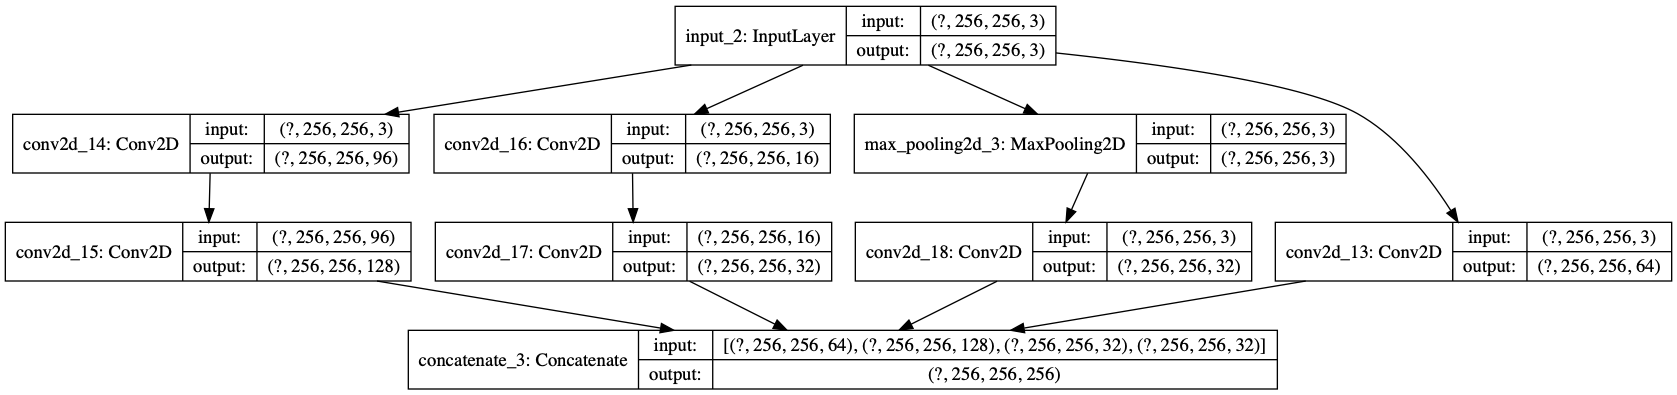

In [6]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='inception_module.png')